This notebook attempts to reproduce the protein similarity matrix your colleague created, in a reproducible way. It runs quite quickly and is very simple.

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


You likely already have `pandas`; the others can be installed via `pip`:

    pip install screed nwalign seaborn

In [2]:
import nwalign as nw
import screed
import pandas as pd
import seaborn as sns

First we grab the sequences and put them in a list. You only have a few dozen, so I just parsed the whole file and stick the records in a `list`. screed's `record` object is pretty straight-forward: it has a `name` attribute with the FASTA header, and a `sequence` attribute with the actual sequence.

In [3]:
records = [record for record in screed.open('Similarity_RawSequences.fasta')]

Now we do the alignments. This is the meat of the notebook. It uses the `nwalign` package you installed above, which you can read more about [here](https://pypi.python.org/pypi/nwalign/?). `nwalign` is a *global* aligner: in a global alignment, we attempt to align the entirety of both sequences, instead of searching for regions of local similarity. The algorithm is called Needleman-Wunsch, which is an *optimal* global alignment, in that it will always find the best possible alignment given a scoring matrix; this is in contrast to other algorithms like BLAST+, which will not always find the optimal alignment but are very fast. You have few sequences, so we opt to get the best alignments.

We're using the BLOSUM90 matrix, which you can read more about [here](https://en.wikipedia.org/wiki/Substitution_matrix). BLOSUM90 is tuned for highly similar sequences, unlike the default BLOSUM62 which is meant for more distant sequences. `nwalign` uses NCBI format matrices, and there is a whole collection of them [here](ftp://ftp.ncbi.nih.gov/blast/matrices/), which is where we will pull your matrix from.

So first, let's get the matrix.

In [15]:
!curl -O ftp://ftp.ncbi.nih.gov/blast/matrices/BLOSUM90

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2122  100  2122    0     0    743      0  0:00:02  0:00:02 --:--:--   743


Now we perform the alignment. This is all-by-all; so, for each record, we iterate through the list of records again and align the two. It is redundant, but it's fast enough not to matter. We stick the results in a dictionary keyed by `(first_record, second_record)`. The parameters to `score_alignment` are also important: we've set the *gap open* score (the penalty for the *first* gap encountered) to -5, and the *gap extension* score (the penalty for each *additional* gap encountered) to -2. These are the BLAST+ defaults and should be reasonable.

In [16]:
results = {}
for record_A in records:
    results[record_A.name] = {}
    for record_B in records:
        # nwalign is funky: it first produces raw alignment strings
        aln_A, aln_B = nw.global_align(record_A.sequence, record_B.sequence, matrix='BLOSUM90')
        # now calc the actual alignment score.
        score = nw.score_alignment(aln_A, aln_B, -5, -2, matrix='BLOSUM90')
        results[record_A.name][record_B.name] = score

Stick the results in a pandas `DataFrame`. It understands dictionaries-of-dictionaries out of the box.

In [53]:
data = pd.DataFrame(results)

In [54]:
data.head()

,2zxq,A2FDT7_TRIVA,Ashanti_Glyco,B1HND6_LYSSC,B2TJW8_CLOBB,B7GRY0_BIFLS,B7VSN0_VIBSL,C0Z6B5_BREBN,C2QAW6_BACCE,C2S2J1_BACCE,...,Q81RR8_BACAN,Q833X5_ENTFA,Q8G622_BIFLO,Q8G712_BIFLO,Q9KMR6_VIBCH,S0EXX9_9BACT,V6KVU1_STRRC,W5W3Z8_9PSEU,W5WMI2_9PSEU,W5X5T4_9BACT
2zxq,8497,-1179,-1017,-782,-727,-1017,-735,-798,-772,-783,...,-753,699,-1026,7170,-850,-634,-855,1019,-952,-769
A2FDT7_TRIVA,-1179,2896,-280,-315,-345,-280,-391,-322,-309,-347,...,-327,-1127,-274,-2158,-377,-878,-349,-913,-375,-352
Ashanti_Glyco,-1017,-280,4061,-264,-311,4061,-227,-184,-203,-256,...,-217,-875,4024,-1866,-112,-613,-150,-725,-148,-308
B1HND6_LYSSC,-782,-315,-264,4783,3246,-264,353,1744,1854,1807,...,1874,-627,-259,-1505,208,-696,-20,-627,-26,-275
B2TJW8_CLOBB,-727,-345,-311,3245,4805,-311,322,1719,1960,1892,...,1959,-625,-301,-1443,212,-661,-46,-589,-51,-295


Create the heatmap and dendrogram using seaborn's `clustermap`. The two extra lines after fix a bug recently introduced to seaborn which causes unreadable labels. Save the resulting figure, and we're done.

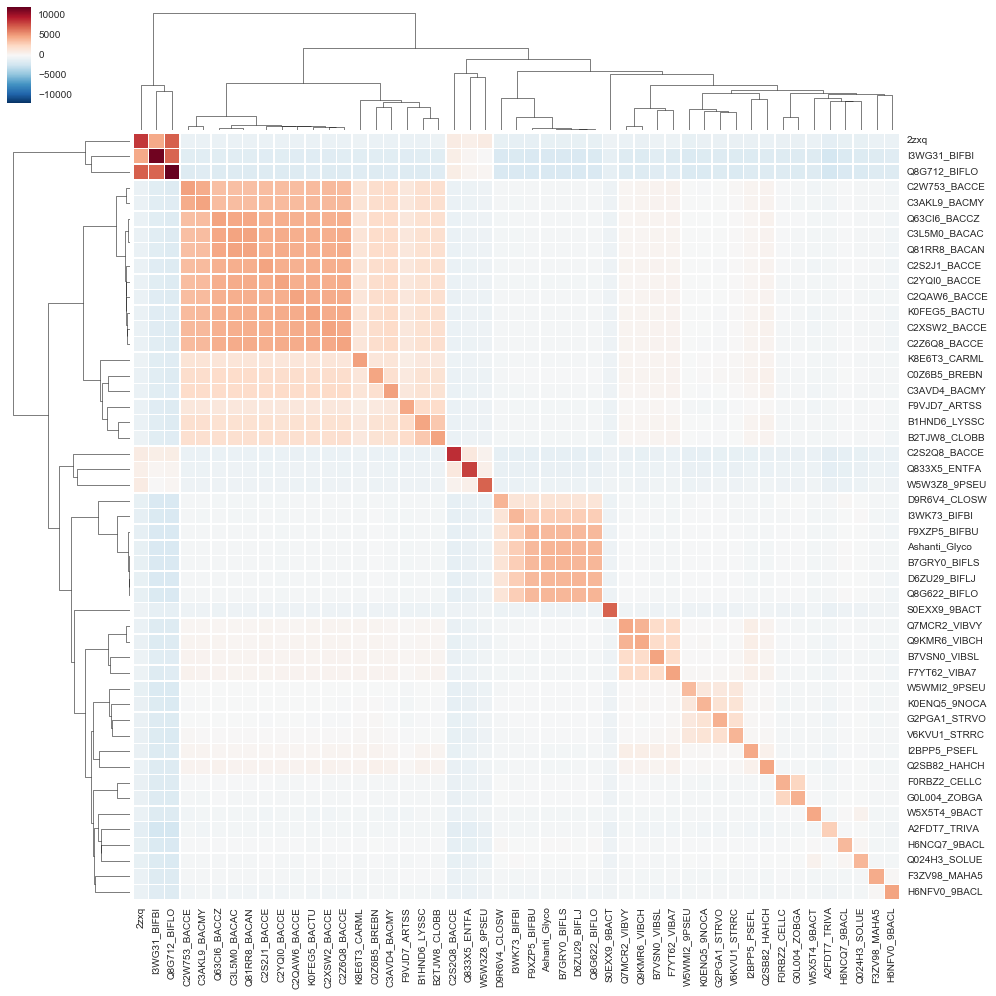

In [55]:
clst = sns.clustermap(data, linewidths=.5, figsize=(16, 16), square=True)
plt.setp(clst.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(clst.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
clst.savefig('similarity_clustermap.pdf')

You might consider normalizing the scores for length, which can be done by dividing out the self alignment score for each element.

In [56]:
for key, row in data.iterrows():
    new_row = row / row[key]
    data.ix[key] = new_row

In [57]:
data.head()

,2zxq,A2FDT7_TRIVA,Ashanti_Glyco,B1HND6_LYSSC,B2TJW8_CLOBB,B7GRY0_BIFLS,B7VSN0_VIBSL,C0Z6B5_BREBN,C2QAW6_BACCE,C2S2J1_BACCE,...,Q81RR8_BACAN,Q833X5_ENTFA,Q8G622_BIFLO,Q8G712_BIFLO,Q9KMR6_VIBCH,S0EXX9_9BACT,V6KVU1_STRRC,W5W3Z8_9PSEU,W5WMI2_9PSEU,W5X5T4_9BACT
2zxq,1.000000,-0.138755,-0.119689,-0.092032,-0.085560,-0.119689,-0.086501,-0.093915,-0.090856,-0.092150,...,-0.088620,0.082264,-0.120748,0.843827,-0.100035,-0.074615,-0.100624,0.119925,-0.112040,-0.090503
A2FDT7_TRIVA,-0.407113,1.000000,-0.096685,-0.108771,-0.119130,-0.096685,-0.135014,-0.111188,-0.106699,-0.119820,...,-0.112914,-0.389157,-0.094613,-0.745166,-0.130180,-0.303177,-0.120511,-0.315262,-0.129489,-0.121547
Ashanti_Glyco,-0.250431,-0.068949,1.000000,-0.065009,-0.076582,1.000000,-0.055898,-0.045309,-0.049988,-0.063039,...,-0.053435,-0.215464,0.990889,-0.459493,-0.027579,-0.150948,-0.036937,-0.178527,-0.036444,-0.075843
B1HND6_LYSSC,-0.163496,-0.065858,-0.055195,1.000000,0.678654,-0.055195,0.073803,0.364625,0.387623,0.377796,...,0.391804,-0.131089,-0.054150,-0.314656,0.043487,-0.145515,-0.004181,-0.131089,-0.005436,-0.057495
B2TJW8_CLOBB,-0.151301,-0.071800,-0.064724,0.675338,1.000000,-0.064724,0.067014,0.357752,0.407908,0.393757,...,0.407700,-0.130073,-0.062643,-0.300312,0.044121,-0.137565,-0.009573,-0.122581,-0.010614,-0.061394


Replot it.

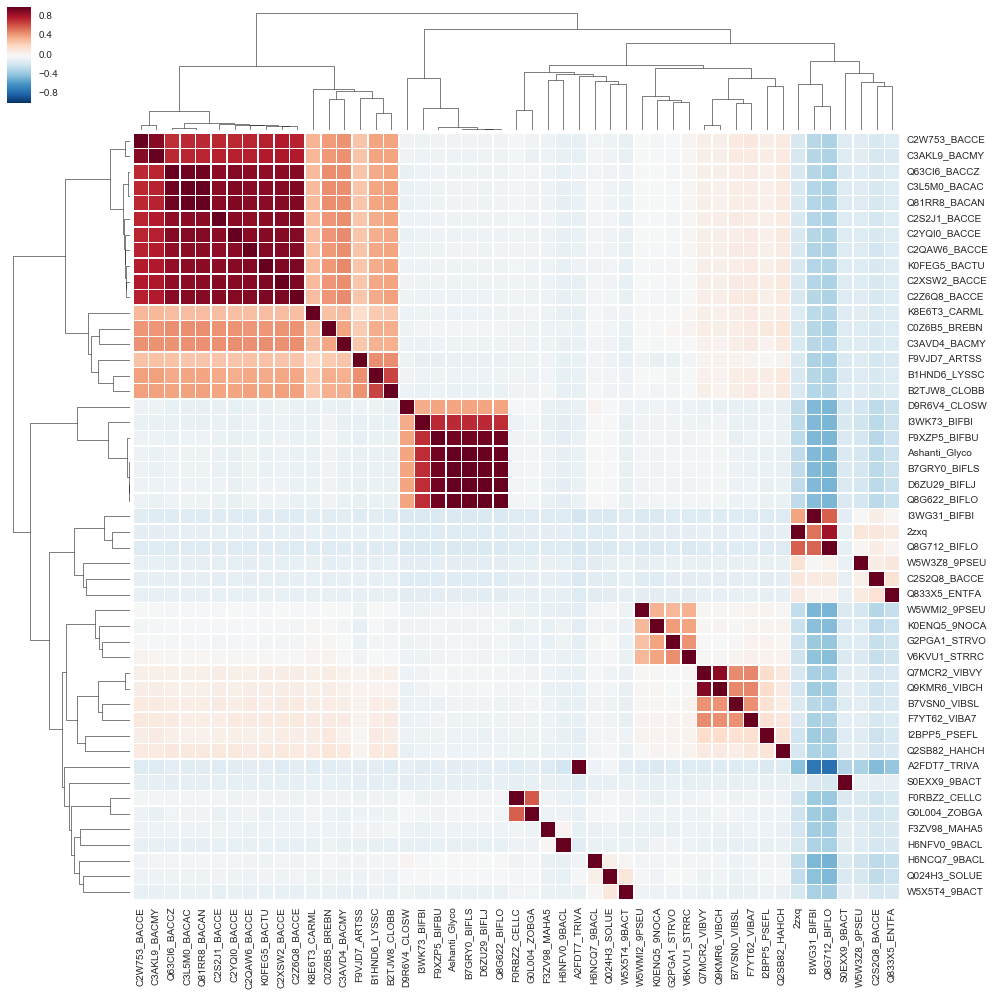

In [58]:
clst = sns.clustermap(data, linewidths=.5, figsize=(16, 16), square=True)
plt.setp(clst.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(clst.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
clst.savefig('similarity_clustermap_normalized.pdf')

Yay, it looks prettier too!